In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV #GridSearch is for hyperparameter tuning
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [32]:
df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1/main/Datasets/Fraud_Detection_Dataset.csv')

In [33]:
df.head()

,Transaction ID,Customer ID,Transaction Amount,Transaction Date and Time,Merchant Category,Location,Previous Transaction Amount,Time Since Last Transaction,Device Type,Fraud
0,1,4174,659.297095,2023-01-01 00:00:00,Clothing,Los Angeles,579.323704,481.377516,desktop,No
1,2,4507,474.046452,2023-01-01 00:01:00,Dining,Houston,407.220271,1159.211075,desktop,No
2,3,1860,498.819570,2023-01-01 00:02:00,Dining,San Francisco,265.583605,720.677284,desktop,No
3,4,2294,744.199592,2023-01-01 00:03:00,Electronics,Los Angeles,1097.259081,1.000000,mobile,No
4,5,2130,279.181247,2023-01-01 00:04:00,Electronics,Los Angeles,238.389682,1378.958721,mobile,No


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Transaction ID               10000 non-null  int64  
 1   Customer ID                  10000 non-null  int64  
 2   Transaction Amount           10000 non-null  float64
 3   Transaction Date and Time    10000 non-null  object 
 4   Merchant Category            10000 non-null  object 
 5   Location                     10000 non-null  object 
 6   Previous Transaction Amount  10000 non-null  float64
 7   Time Since Last Transaction  10000 non-null  float64
 8   Device Type                  10000 non-null  object 
 9   Fraud                        10000 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 781.4+ KB


In [7]:
df.describe()

,Transaction ID,Customer ID,Transaction Amount,Previous Transaction Amount,Time Since Last Transaction
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,3010.561100,559.865608,461.410984,677.040726
std,2886.89568,1152.371939,399.984400,334.582413,432.386769
min,1.00000,1000.000000,1.000000,0.000000,1.000000
25%,2500.75000,2001.750000,262.969956,181.109688,295.523894
50%,5000.50000,3004.000000,522.370941,404.367010,653.143168
75%,7500.25000,4010.000000,788.415931,676.079655,1048.479972
max,10000.00000,4999.000000,2953.394492,1500.000000,1694.715674


In [34]:
# with the pd.to_datetime() function we can make the change
df['Transaction Date and Time'] = pd.to_datetime(df['Transaction Date and Time'])

In [12]:
df.head()

,Transaction ID,Customer ID,Transaction Amount,Transaction Date and Time,Merchant Category,Location,Previous Transaction Amount,Time Since Last Transaction,Device Type,Fraud
0,1,4174,659.297095,2023-01-01 00:00:00,Clothing,Los Angeles,579.323704,481.377516,desktop,No
1,2,4507,474.046452,2023-01-01 00:01:00,Dining,Houston,407.220271,1159.211075,desktop,No
2,3,1860,498.819570,2023-01-01 00:02:00,Dining,San Francisco,265.583605,720.677284,desktop,No
3,4,2294,744.199592,2023-01-01 00:03:00,Electronics,Los Angeles,1097.259081,1.000000,mobile,No
4,5,2130,279.181247,2023-01-01 00:04:00,Electronics,Los Angeles,238.389682,1378.958721,mobile,No


In [35]:
# isolate the hour of the day to assess time of day
df['hour'] = df['Transaction Date and Time'].apply(lambda x: x.hour)

In [47]:
df.groupby('Fraud')['hour'].count()

Fraud
No     8608
Yes    1392
Name: hour, dtype: int64

In [14]:
df.head()

,Transaction ID,Customer ID,Transaction Amount,Transaction Date and Time,Merchant Category,Location,Previous Transaction Amount,Time Since Last Transaction,Device Type,Fraud,hour
0,1,4174,659.297095,2023-01-01 00:00:00,Clothing,Los Angeles,579.323704,481.377516,desktop,No,0
1,2,4507,474.046452,2023-01-01 00:01:00,Dining,Houston,407.220271,1159.211075,desktop,No,0
2,3,1860,498.819570,2023-01-01 00:02:00,Dining,San Francisco,265.583605,720.677284,desktop,No,0
3,4,2294,744.199592,2023-01-01 00:03:00,Electronics,Los Angeles,1097.259081,1.000000,mobile,No,0
4,5,2130,279.181247,2023-01-01 00:04:00,Electronics,Los Angeles,238.389682,1378.958721,mobile,No,0


In [36]:
def time_of_day(x):
    if x >= 6 and x <= 12:
        return 'morning'
    elif x > 12 and x <= 18:
        return 'afternoon'
    elif x > 18 and x <= 24:
        return 'night'
    else:
        return 'latenight' 

In [37]:
df['time_of_day'] = df['hour'].apply(time_of_day)

In [38]:
df.head()

,Transaction ID,Customer ID,Transaction Amount,Transaction Date and Time,Merchant Category,Location,Previous Transaction Amount,Time Since Last Transaction,Device Type,Fraud,hour,time_of_day
0,1,4174,659.297095,2023-01-01 00:00:00,Clothing,Los Angeles,579.323704,481.377516,desktop,No,0,latenight
1,2,4507,474.046452,2023-01-01 00:01:00,Dining,Houston,407.220271,1159.211075,desktop,No,0,latenight
2,3,1860,498.819570,2023-01-01 00:02:00,Dining,San Francisco,265.583605,720.677284,desktop,No,0,latenight
3,4,2294,744.199592,2023-01-01 00:03:00,Electronics,Los Angeles,1097.259081,1.000000,mobile,No,0,latenight
4,5,2130,279.181247,2023-01-01 00:04:00,Electronics,Los Angeles,238.389682,1378.958721,mobile,No,0,latenight


/var/folders/03/qxtr7cc92pg1c6lvx8kqq6f80000gn/T/ipykernel_57159/3092897220.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='time_of_day', y='Merchant Category', data=df, ax=ax1, palette='tab10')
/var/folders/03/qxtr7cc92pg1c6lvx8kqq6f80000gn/T/ipykernel_57159/3092897220.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='time_of_day', y='Location', data=df, ax=ax2, palette='tab10')
/var/folders/03/qxtr7cc92pg1c6lvx8kqq6f80000gn/T/ipykernel_57159/3092897220.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='time_of_day', y='Devi

Text(0, 0.5, 'Device Type')

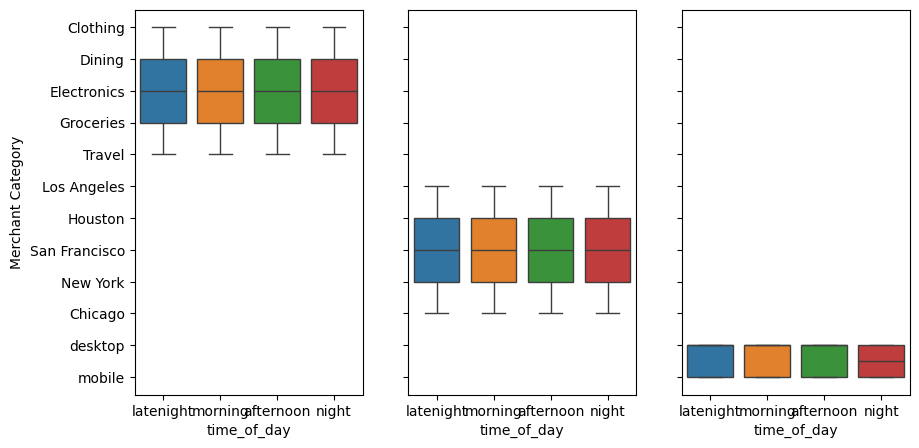

In [39]:
# evaluate time_of_day vs number of casual or registered or total rentals
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (10,5), sharey=True)
sns.boxplot(x='time_of_day', y='Merchant Category', data=df, ax=ax1, palette='tab10')
sns.boxplot(x='time_of_day', y='Location', data=df, ax=ax2, palette='tab10')
sns.boxplot(x='time_of_day', y='Device Type', data=df, ax=ax3, palette='tab10')

ax2.set_ylabel('Location')
ax3.set_ylabel('Device Type')

Text(0, 0.5, 'Device Type')

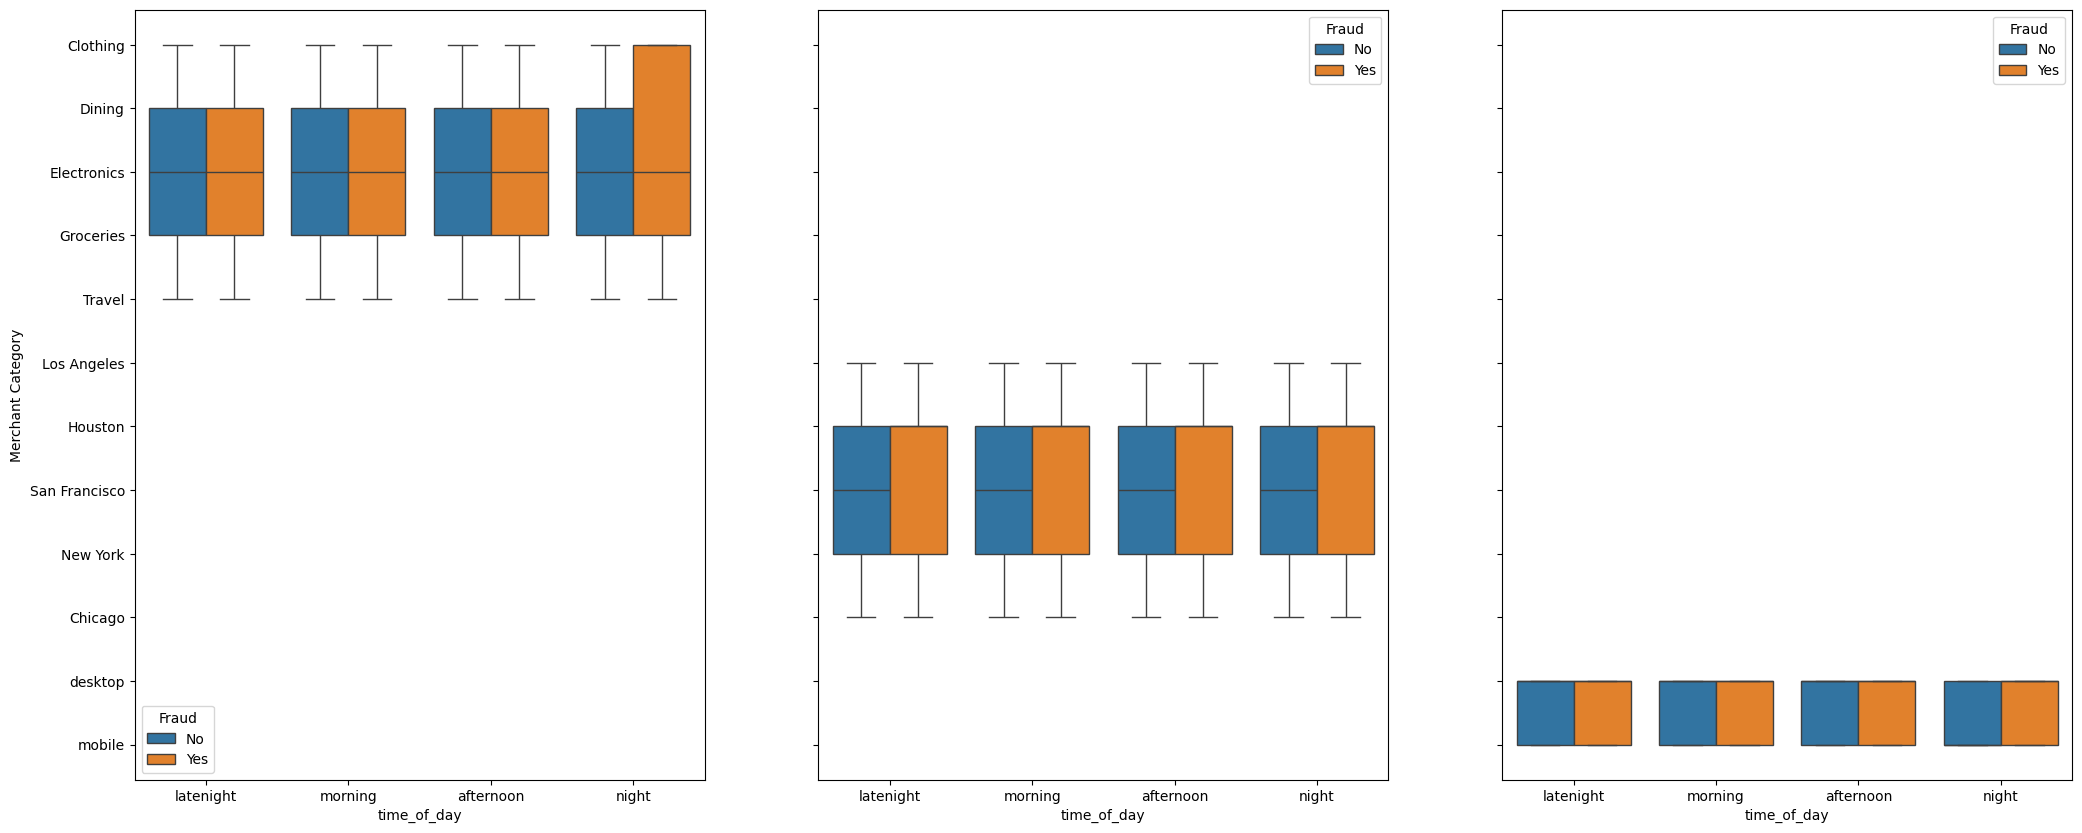

In [40]:
# evaluate weekday & time_of_day vs number of casual or registered or total rentals
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (25,10), sharey=True)
sns.boxplot(x='time_of_day', y='Merchant Category', hue='Fraud',data=df, ax=ax1, palette='tab10')
sns.boxplot(x='time_of_day', y='Location', hue='Fraud',data=df, ax=ax2, palette='tab10')
sns.boxplot(x='time_of_day', y='Device Type', hue='Fraud',data=df, ax=ax3, palette='tab10')

ax2.set_ylabel('Location')
ax3.set_ylabel('Device Type')

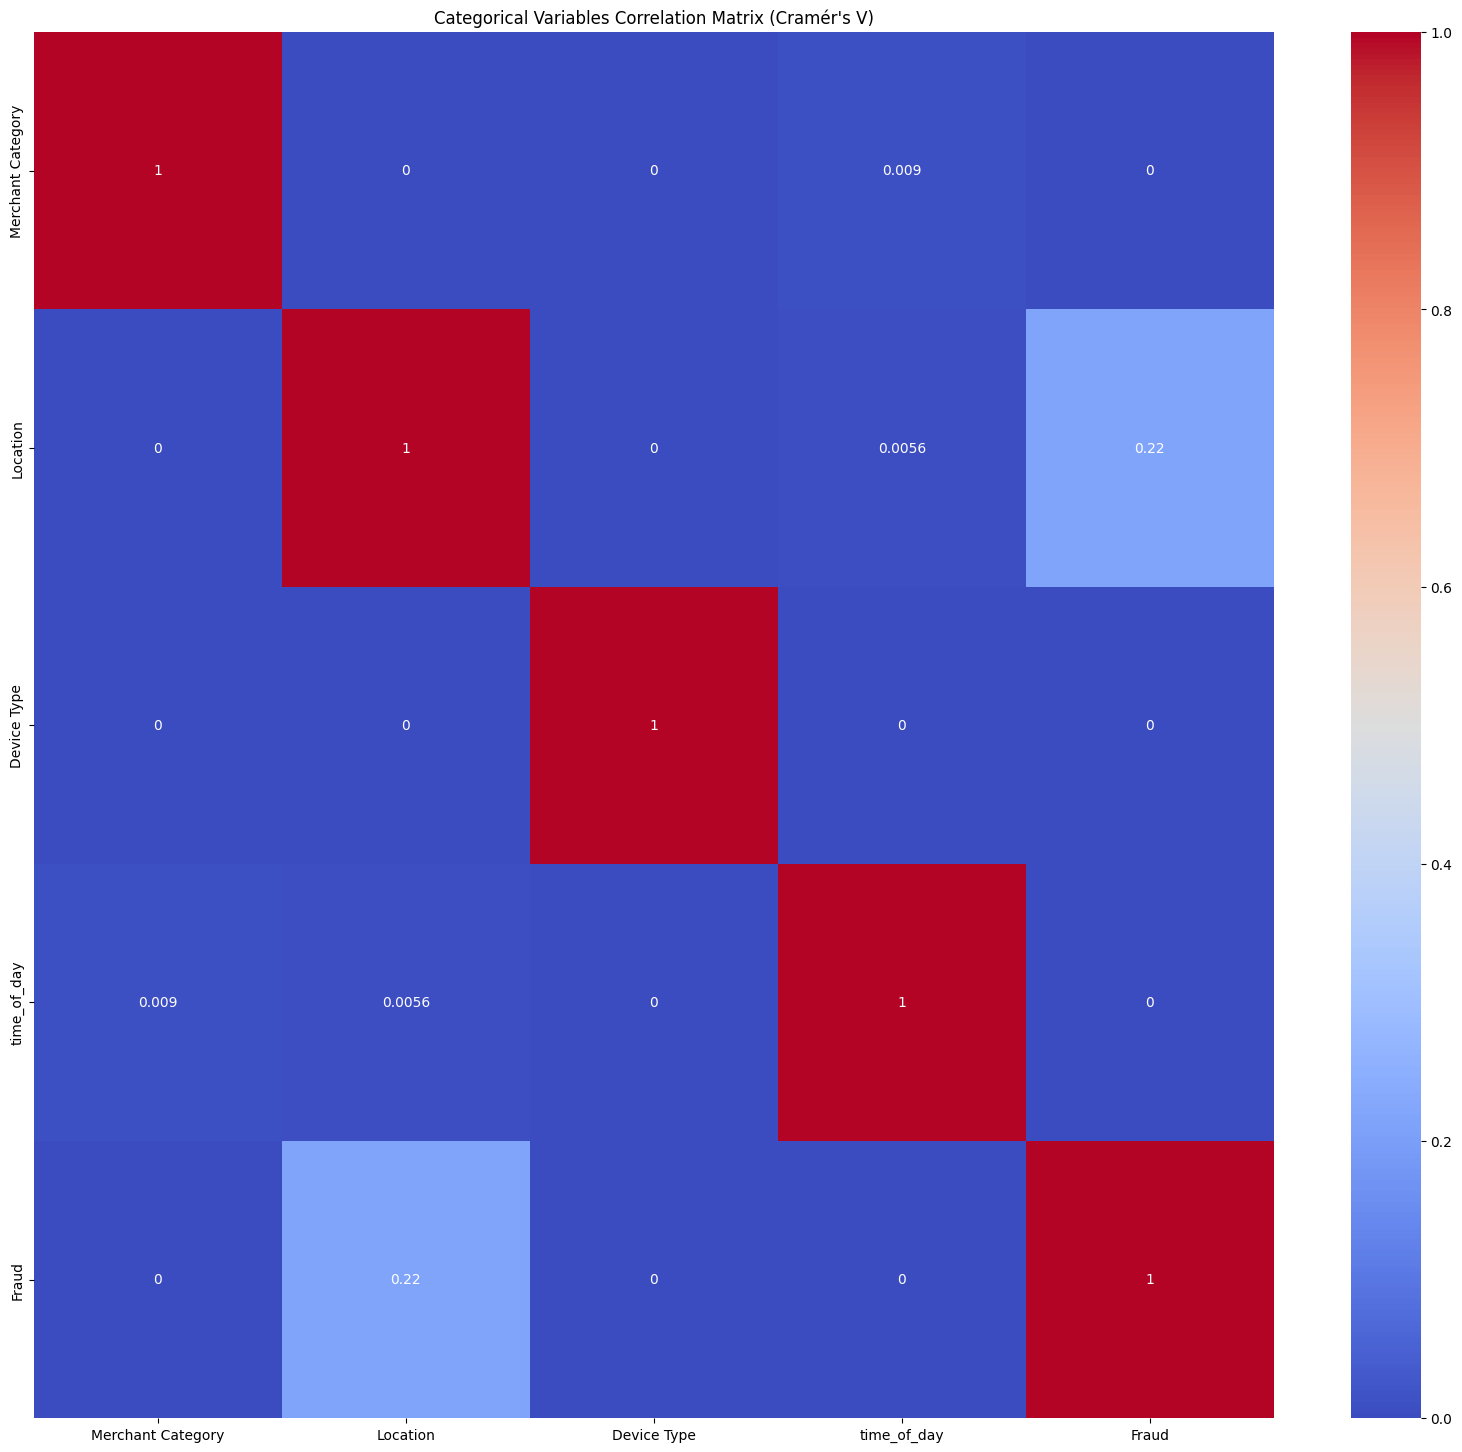

In [41]:
def cramers_v(confusion_matrix):
    """Calculate Cramér's V for the given confusion matrix."""
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()  # Get total number of observations
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1) if n > 1 else 0)
    rcorr = r - ((r-1)**2)/(n-1) if n > 1 else r
    kcorr = k - ((k-1)**2)/(n-1) if n > 1 else k
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Select the categorical variables that you want to analyze
categorical_cols = ['Merchant Category', 'Location', 
         'Device Type', 'time_of_day','Fraud']
# Clean data to remove missing values
corr_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

for col1 in categorical_cols:
    for col2 in categorical_cols:
        if col1 == col2:
            corr_matrix.loc[col1, col2] = 1.0
        else:
            confusion_matrix = pd.crosstab(df[col1], df[col2])
            corr_matrix.loc[col1, col2] = cramers_v(confusion_matrix)

# Convert the data type to floating-point
corr_matrix = corr_matrix.astype(float)

# Visual correlation matrix
plt.figure(figsize=(20, 18))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Categorical Variables Correlation Matrix (Cramér\'s V)')
plt.show()

In [43]:
# test whether the difference of yes answer rate in each 'Merchant Category' is statistically significant
# Create a contingency table for 'Merchant Category' and 'Fraud'
contingency_table_cate = pd.crosstab(df['Merchant Category'], df['Fraud'])

# Perform Chi-Square test
chi2_cate, p_cate, dof_cate, expected_cate = stats.chi2_contingency(contingency_table_cate)

# Display the results
chi2_cate, p_cate

(2.422844794447375, 0.6585028234725516)

In [44]:
# test whether the difference of yes answer rate in each 'Location' is statistically significant
# Create a contingency table for 'Location' and 'Fraud'
contingency_table_loca = pd.crosstab(df['Location'], df['Fraud'])

# Perform Chi-Square test
chi2_loca, p_loca, dof_loca, expected_loca = stats.chi2_contingency(contingency_table_loca)

# Display the results
chi2_loca, p_loca

(469.5569492557882, 2.567486407847484e-100)

In [46]:
# test whether the difference of yes answer rate in each 'time_of_day' is statistically significant
# Create a contingency table for 'time_of_day' and 'Fraud'
contingency_table_time = pd.crosstab(df['time_of_day'], df['Fraud'])

# Perform Chi-Square test
chi2_time, p_time, dof_time, expected_time = stats.chi2_contingency(contingency_table_time)

# Display the results
chi2_time, p_time

(1.4212719316258329, 0.7005561352887111)

In [45]:

# test whether the difference of yes answer rate in each 'Device Type' is statistically significant
# Create a contingency table for 'Device Type' and 'Fraud'
contingency_table_devi = pd.crosstab(df['Device Type'], df['Fraud'])

# Perform Chi-Square test
chi2_devi, p_devi, dof_devi, expected_devi = stats.chi2_contingency(contingency_table_devi)

# Display the results
chi2_devi, p_devi

(0.01652777685241005, 0.8977055011815493)

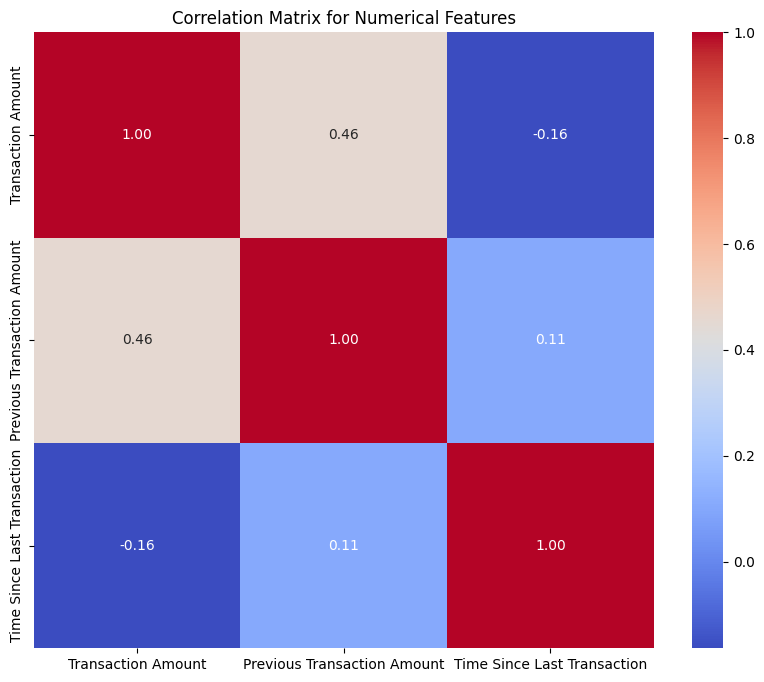

In [48]:
# Compute the correlation matrix for numerical columns only
numerical_columns = ['Transaction Amount', 'Previous Transaction Amount', 'Time Since Last Transaction']

corr_matrix = df[numerical_columns].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix for Numerical Features')
plt.show()

In [49]:
# Convert the 'Attrition' column: 'Yes' to 1 and 'No' to 0
df['Fraud'] = df['Fraud'].apply(lambda x: 1 if x == 'Yes' else 0)

# Display the first few rows to confirm the change
df.head()


,Transaction ID,Customer ID,Transaction Amount,Transaction Date and Time,Merchant Category,Location,Previous Transaction Amount,Time Since Last Transaction,Device Type,Fraud,hour,time_of_day
0,1,4174,659.297095,2023-01-01 00:00:00,Clothing,Los Angeles,579.323704,481.377516,desktop,0,0,latenight
1,2,4507,474.046452,2023-01-01 00:01:00,Dining,Houston,407.220271,1159.211075,desktop,0,0,latenight
2,3,1860,498.819570,2023-01-01 00:02:00,Dining,San Francisco,265.583605,720.677284,desktop,0,0,latenight
3,4,2294,744.199592,2023-01-01 00:03:00,Electronics,Los Angeles,1097.259081,1.000000,mobile,0,0,latenight
4,5,2130,279.181247,2023-01-01 00:04:00,Electronics,Los Angeles,238.389682,1378.958721,mobile,0,0,latenight


In [50]:
# Define the numeric features and the target variable
numeric_features = ['Transaction Amount', 'Previous Transaction Amount', 'Time Since Last Transaction']
target = 'Fraud'

# Ensure 'Fraud' is binary and convert to integer type
df[target] = df[target].astype(int)

# Perform t-tests for each numeric feature
t_test_results = {}
for feature in numeric_features:
    no_attrition = df[df[target] == 0][feature]
    yes_attrition = df[df[target] == 1][feature]
    t_stat, p_value = stats.ttest_ind(no_attrition, yes_attrition, equal_var=False)
    t_test_results[feature] = (t_stat, p_value)

# Display the results
t_test_results

{'Transaction Amount': (-22.903247525251736, 1.2212097932148008e-99),
 'Previous Transaction Amount': (27.70538944496681, 3.637687769574472e-144),
 'Time Since Last Transaction': (30.80421715932078, 2.1537931014484865e-171)}

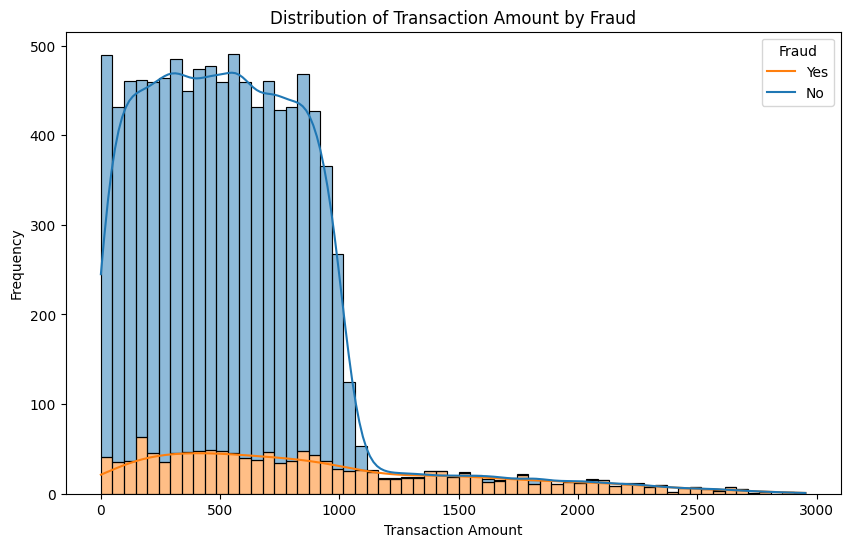

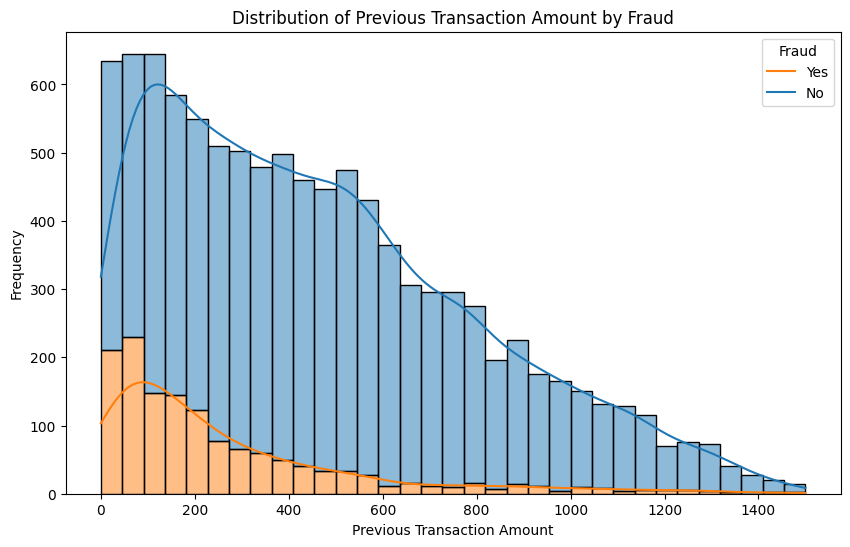

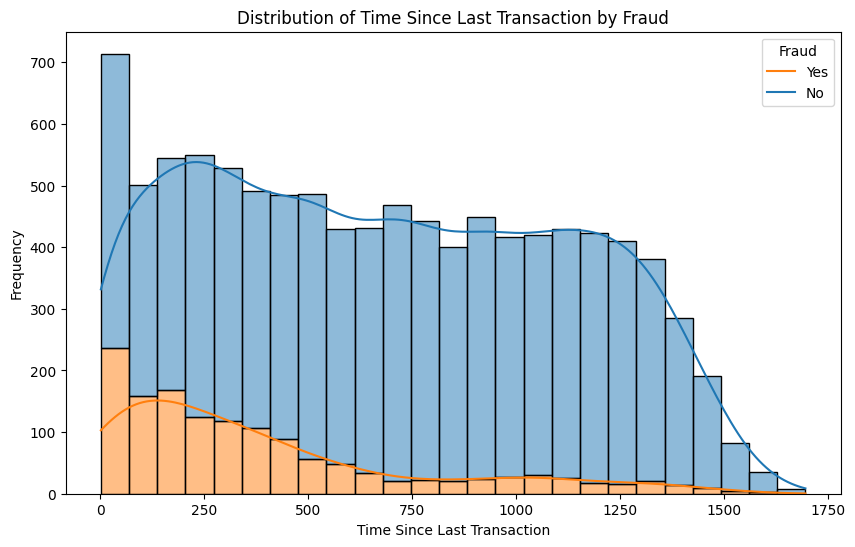

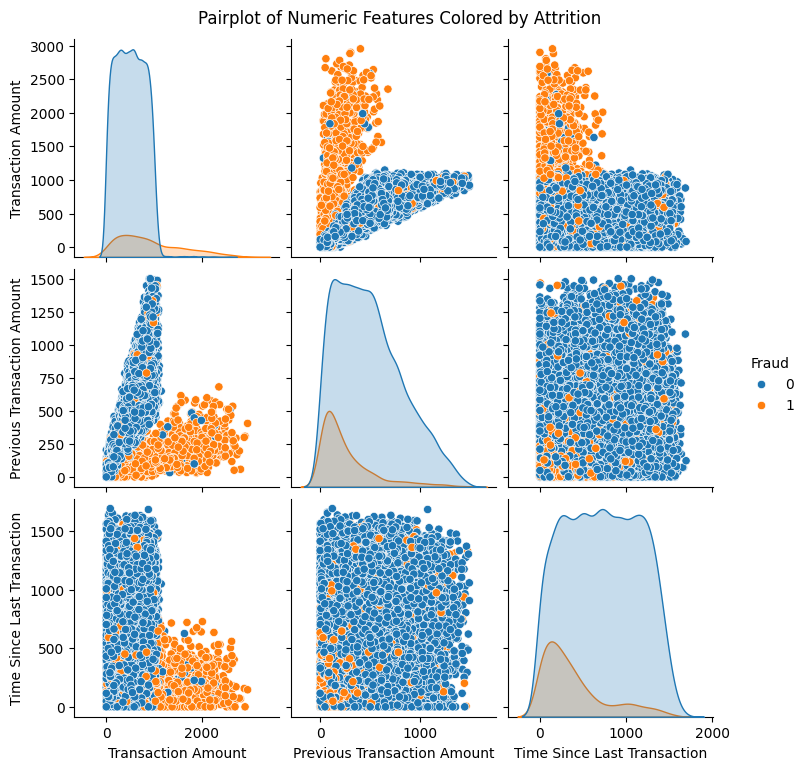

In [51]:
# Function to plot distributions
def plot_distribution(feature):
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=feature, hue=target, multiple="stack", kde=True)
    plt.title(f'Distribution of {feature} by Fraud')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend(title='Fraud', labels=['Yes', 'No'])
    plt.show()

# Plot distributions for numeric features
for feature in numeric_features:
    plot_distribution(feature)

# Pairplot to see interactions
sns.pairplot(df, hue=target, vars=numeric_features, diag_kind='kde', height=2.5)
plt.suptitle('Pairplot of Numeric Features Colored by Attrition', y=1.02)
plt.show()

In [52]:
X = df[['Location', 'Transaction Amount', 'Previous Transaction Amount', 
                     'Time Since Last Transaction']]
y = df['Fraud']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

# build our pipeline that includes these transformations
numeric_columns = ['Transaction Amount', 'Previous Transaction Amount', 
                     'Time Since Last Transaction']
categorical_columns = ['Location']

preprocessor = ColumnTransformer(
    transformers=[
        ('num',MinMaxScaler(), numeric_columns),
        ('cat',OneHotEncoder(handle_unknown='ignore'),categorical_columns)
    ]
)

In [53]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [54]:
# Define the models
knn = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', KNeighborsClassifier())])
logreg = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression())])
nb = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', GaussianNB())])
svm = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', SVC())])
dt = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', DecisionTreeClassifier())])

# Cross validation to determine in general which model works best for the given problem
knn_scores = cross_val_score(knn, X_train, y_train, scoring='f1', cv=5)
logreg_scores = cross_val_score(logreg, X_train, y_train, scoring='f1', cv=5)
nb_scores = cross_val_score(nb, X_train, y_train, scoring='f1', cv=5)
svm_scores = cross_val_score(svm, X_train, y_train, scoring='f1', cv=5)
dt_scores = cross_val_score(dt, X_train, y_train, scoring='f1', cv=5)

# Print the average F1 scores for each model
print('KNN F1 Score:', np.mean(knn_scores))
print('Logistic Regression F1 Score:', np.mean(logreg_scores))
print('Naive Bayes F1 Score:', np.mean(nb_scores))
print('SVM F1 Score:', np.mean(svm_scores))
print('Decision Tree F1 Score:', np.mean(dt_scores))

KNN F1 Score: 0.7215602031145473
Logistic Regression F1 Score: 0.6346014313723485
Naive Bayes F1 Score: 0.580478618096173
SVM F1 Score: 0.6593915465610476
Decision Tree F1 Score: 0.5915150061270301


In [55]:
# Since the target is imbalanced, use f1-weighted score instead of f1 score
# Cross validation to determine in general which model works best for the given problem
knn_scores = cross_val_score(knn, X_train, y_train, scoring='f1_weighted', cv=5)
logreg_scores = cross_val_score(logreg, X_train, y_train, scoring='f1_weighted', cv=5)
nb_scores = cross_val_score(nb, X_train, y_train, scoring='f1_weighted', cv=5)
svm_scores = cross_val_score(svm, X_train, y_train, scoring='f1_weighted', cv=5)
dt_scores = cross_val_score(dt, X_train, y_train, scoring='f1_weighted', cv=5)

# Print the average weighted F1 scores for each model
print('KNN Weighted F1 Score:', np.mean(knn_scores))
print('Logistic Regression Weighted F1 Score:', np.mean(logreg_scores))
print('Naive Bayes Weighted F1 Score:', np.mean(nb_scores))
print('SVM Weighted F1 Score:', np.mean(svm_scores))
print('Decision Tree Weighted F1 Score:', np.mean(dt_scores))

KNN Weighted F1 Score: 0.9289585371999383
Logistic Regression Weighted F1 Score: 0.9110479654776661
Naive Bayes Weighted F1 Score: 0.886852542965614
SVM Weighted F1 Score: 0.9163282823564254
Decision Tree Weighted F1 Score: 0.8834167484142457


In [56]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [59]:
# Pipeline for KNeighborsClassifier
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# Parameter grid for Grid Search
param_dist_knn = {
    'classifier__n_neighbors': [5, 7, 9, 15, 35, 45, 55],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski']
}

# Perform Randomized Search for KNN
grid_search_knn = GridSearchCV(knn_pipeline, param_dist_knn, cv=5, verbose=1, scoring='f1_weighted')
grid_search_knn.fit(X_train, y_train)

print("Best KNN parameters:", grid_search_knn.best_params_)
print("Best KNN F1 score:", grid_search_knn.best_score_)


Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best KNN parameters: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 7, 'classifier__weights': 'uniform'}
Best KNN F1 score: 0.930569286951138


In [60]:

# Best KNN parameters: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 7, 'classifier__weights': 'uniform'}

best_params = grid_search_knn.best_params_

# Final KNeighborsClassifier with best parameters
final_classifier = KNeighborsClassifier(
    n_neighbors=best_params['classifier__n_neighbors'],
    metric=best_params['classifier__metric'],
    weights=best_params['classifier__weights']
)

# Create the final pipeline
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', final_classifier)
])

# Fit the final pipeline on the training data
final_pipeline.fit(X_train, y_train)

# Predict the results on the test set
pred = final_pipeline.predict(X_test)

# Predict the probability of the results on the test set
probs = final_pipeline.predict_proba(X_test)

# Display the results
print("Predictions:", pred)
print("Prediction Probabilities:", probs)

Predictions: [0 0 0 ... 0 0 0]
Prediction Probabilities: [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [64]:
# Calculate the scores
f1 = f1_score(y_test, pred)
accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)

# Display the results
print("Weighted F1 Score:", f1)
print("Accuracy Score:", accuracy)
print("Weighted Precision Score:", precision)
print("Weighted Recall Score:", recall)

Weighted F1 Score: 0.7228177641653905
Accuracy Score: 0.9396666666666667
Weighted Precision Score: 0.932806324110672
Weighted Recall Score: 0.59


In [62]:
from sklearn.metrics import f1_score, PrecisionRecallDisplay, precision_score, recall_score, roc_auc_score, RocCurveDisplay, roc_curve, confusion_matrix

Text(0.5, 23.52222222222222, 'Predicted Classes')

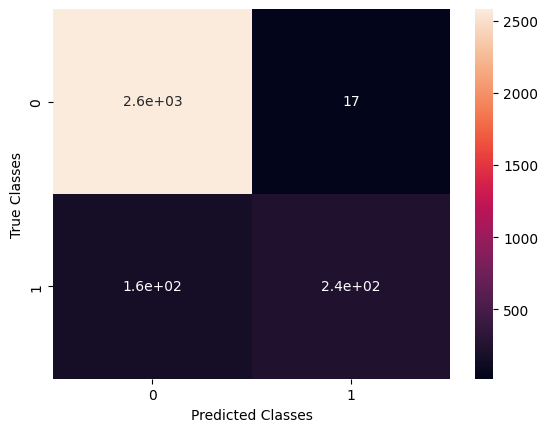

In [65]:
sns.heatmap(confusion_matrix(y_test, pred), annot=True)
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')

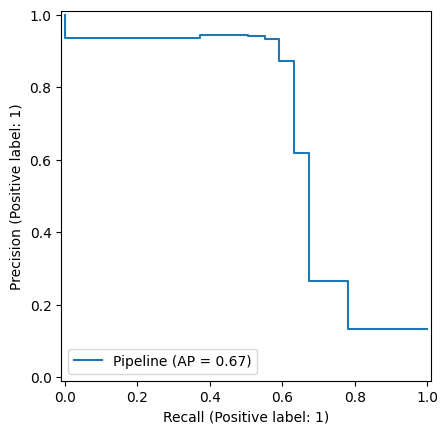

In [66]:
# Precision Recall Curve
display = PrecisionRecallDisplay.from_estimator(final_pipeline, X_test, y_test)

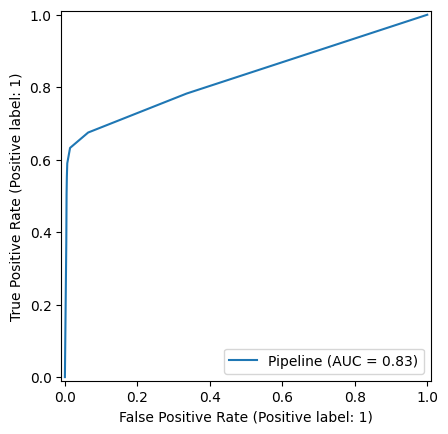

In [67]:
# Display ROC curve for Decision Tree
RocCurveDisplay.from_estimator(final_pipeline, X_test, y_test)
plt.show()


In [76]:

from sklearn.inspection import permutation_importance

In [78]:
# Calculate permutation importance
result = permutation_importance(final_pipeline, X_test, y_test, n_repeats=10, random_state=42, scoring='f1')

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean,
    'Std Dev': result.importances_std
})

# Sorting the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the DataFrame
print(importance_df)



                       Feature  Importance   Std Dev
2  Previous Transaction Amount    0.361285  0.013735
1           Transaction Amount    0.297670  0.018408
3  Time Since Last Transaction    0.171954  0.014932
0                     Location    0.015218  0.009229


In [68]:
# adjust to 30% threshold try to increase the recall
new_predictions =[]
for i in probs[:,1]:
    if i >= 0.3:
        new_predictions.append(1)
    else:
        new_predictions.append(0)

In [70]:
new_f1 = f1_score(y_test, new_predictions)
new_accuracy = accuracy_score(y_test,new_predictions)
new_precision = precision_score(y_test,new_predictions)
new_recall = recall_score(y_test,new_predictions)

# Display the results
print("F1 Score:", new_f1)
print("Accuracy Score:", new_accuracy)
print("Precision Score:", new_precision)
print("Recall Score:", new_recall)

Weighted F1 Score: 0.7333333333333333
Accuracy Score: 0.9386666666666666
Weighted Precision Score: 0.8724137931034482
Weighted Recall Score: 0.6325
